In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
import warnings
warnings.filterwarnings('ignore')
import cmath
import esmlab
import ncar_jobqueue
from dask.distributed import Client
import cmocean

In [2]:
ds = xr.open_mfdataset('/glade/work/kristenk/GLODAPv2_regridded/*.nc',decode_times=False,decode_coords=False)

In [3]:
ds = ds.rename({'depth_surface':'depth'})

### First, define PAlk and nNO3

In [4]:
no3_sf=1 #1.36 in Fry et al. (2015), 1 in Sarmiento et al. (2002)

PAlk=(ds.TAlk + no3_sf * ds.NO3)/ ds.salinity * 35.

nNO3=ds.NO3 * 35./ds.salinity

In [5]:
PAlk

<xarray.DataArray (depth: 33, lat: 180, lon: 360)>
dask.array<mul, shape=(33, 180, 360), dtype=float32, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Attributes:
    long_name:  total alkalinity
    units:      micromol kg-1

In [6]:
#add them to the dataset
ds['PAlk'] = xr.DataArray(PAlk,dims=('depth','lat','lon'))
ds['nNO3'] = xr. DataArray(nNO3,dims=('depth','lat','lon'))

### Make "surface' and 'deep' averages

In [7]:
ds.depth

<xarray.DataArray 'depth' (depth: 33)>
array([   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,  200.,
        250.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100.,
       1200., 1300., 1400., 1500., 1750., 2000., 2500., 3000., 3500., 4000.,
       4500., 5000., 5500.])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Attributes:
    long_name:  depth
    units:      m
    positive:   down

In [8]:
# not sure how would be the proper way to make these averages from the GLODAP depth surfaces
# so I will just take depths 0,10,20,30,50,75m average for the surface box
# and take 100,125,150,200m average for the deep box
# Sarmiento et al. (2002): surface box is 0-100m and deep box is 100-200m

PAlk_surface = ds.PAlk.isel(depth=slice(0,6)).mean(dim='depth')
PAlk_deep = ds.PAlk.isel(depth=slice(6,10)).mean(dim='depth')

nNO3_surface = ds.nNO3.isel(depth=slice(0,6)).mean(dim='depth') #tested at slice(0,5)
nNO3_deep = ds.nNO3.isel(depth=slice(6,10)).mean(dim='depth') #tested at slice(7,10)

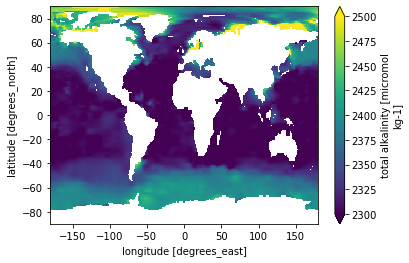

In [9]:
PAlk_surface.plot(vmin=2300,vmax=2500)

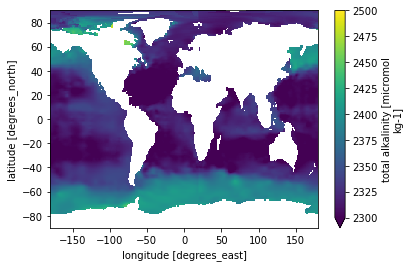

In [10]:
PAlk_deep.plot(vmin=2300,vmax=2500)

In [11]:
area = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))

In [12]:
j=0

for lat in ds.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1.
    resolution_lon =1.

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1


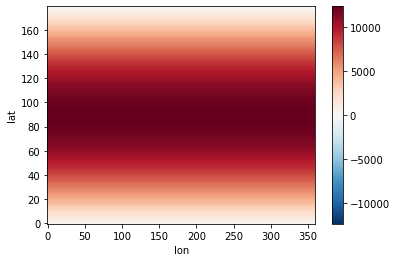

In [13]:
area.plot()

In [14]:
ds['area']=area

In [15]:
rain_ratio=(1/14.6) * ((PAlk_deep - PAlk_surface)/(nNO3_deep - nNO3_surface))

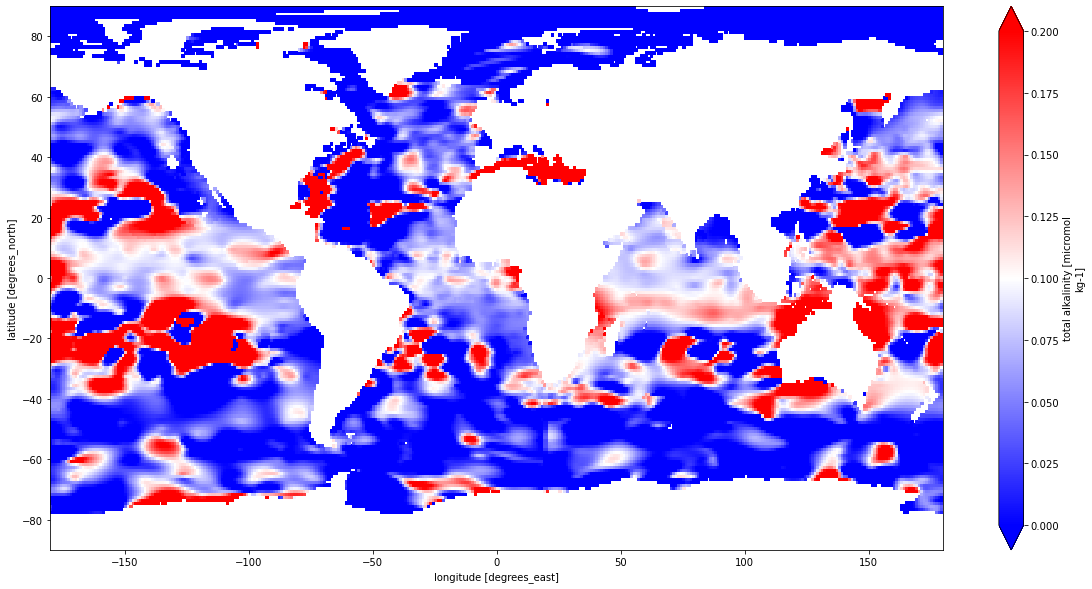

In [16]:
rain_ratio.plot(vmin=0,vmax=0.2,figsize=(20,10),cmap='bwr',)

### Sarmiento et al 2002 global average export ratio = 0.056

In [17]:
#global_mean_rr = rain_ratio.mean()
global_mean_rr = esmlab.weighted_mean(rain_ratio, weights=ds.area, dim=['lat', 'lon']).compute()
global_mean_rr

<xarray.DataArray ()>
array(0.06074744)
Attributes:
    long_name:  total alkalinity
    units:      micromol kg-1

In [18]:
#don't include the Arctic
global_mean_rr = rain_ratio.isel(lat=slice(0,165)).mean()
global_mean_rr = esmlab.weighted_mean(rain_ratio.isel(lat=slice(0,165)), weights=ds.area.isel(lat=slice(0,165)), dim=['lat', 'lon']).compute()
global_mean_rr

<xarray.DataArray ()>
array(0.07139186)
Attributes:
    long_name:  total alkalinity
    units:      micromol kg-1

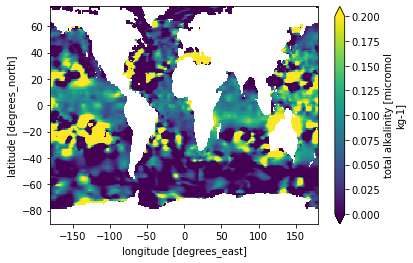

In [19]:
#map of rain ratio (without Arctic)
rain_ratio.isel(lat=slice(0,165)).plot(vmin=0,vmax=0.2)

In [20]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Now do CESM rain ratio

In [43]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean5thIAF'

In [44]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_POC_FLUX_IN.nc'
cesm_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [45]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_CaCO3_FLUX_IN.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['CaCO3_FLUX_IN']=ds_tmp['CaCO3_FLUX_IN']

In [46]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_NO3.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['NO3']=ds_tmp['NO3']

In [47]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_SALT.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['SALT']=ds_tmp['SALT']

In [48]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_ALK.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['ALK']=ds_tmp['ALK']

In [49]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_ALK_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [50]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean5thIAF'

In [51]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_ALK_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [53]:
no3_sf=1 #1.36 in Fry et al., 2015 (accounts for other ions used in primary production)
nNO3=cesm_ds.NO3 * 35./cesm_ds.SALT

PAlk=(cesm_ds.ALK + no3_sf * cesm_ds.NO3)/ cesm_ds.SALT * 35.
PAlk_2xGCB = (cesm_ds.ALK_2xGCB + no3_sf * cesm_ds.NO3)/ cesm_ds.SALT * 35.
PAlk_noGCB = (cesm_ds.ALK_noGCB + no3_sf * cesm_ds.NO3)/ cesm_ds.SALT * 35.

In [55]:
#add them to the dataset
cesm_ds['PAlk'] = xr.DataArray(PAlk,dims=('z_t','nlat','nlon'))
cesm_ds['PAlk_2xGCB'] = xr.DataArray(PAlk_2xGCB,dims=('z_t','nlat','nlon'))
cesm_ds['PAlk_noGCB'] = xr.DataArray(PAlk_noGCB,dims=('z_t','nlat','nlon'))
cesm_ds['nNO3'] = xr. DataArray(nNO3,dims=('z_t','nlat','nlon'))

In [57]:
depths_m = cesm_ds.z_t / 100.

#### for CESM, I take the average over top 10 levels (0-100m) for the surface box
#### and levels 11 to 20 (100-200m) for the deep box

#### Sarmiento et al. (2002): surface box is 0-100m and deep box is 100-200m

In [58]:
nNO3_surface = cesm_ds.nNO3.isel(z_t=slice(0,10)).mean(dim='z_t')
nNO3_deep = cesm_ds.nNO3.isel(z_t=slice(10,20)).mean(dim='z_t') 


## CONTROL #######################################################
PAlk_surface = cesm_ds.PAlk.isel(z_t=slice(0,10)).mean(dim='z_t')
PAlk_deep = cesm_ds.PAlk.isel(z_t=slice(10,20)).mean(dim='z_t')

cesm_rain_ratio=(1/14.6) * ((PAlk_deep - PAlk_surface)/(nNO3_deep - nNO3_surface))

In [59]:
## noGCB #######################################################
PAlk_surface = cesm_ds.PAlk_noGCB.isel(z_t=slice(0,10)).mean(dim='z_t')
PAlk_deep = cesm_ds.PAlk_noGCB.isel(z_t=slice(10,20)).mean(dim='z_t')

cesm_rain_ratio_noGCB=(1/14.6) * ((PAlk_deep - PAlk_surface)/(nNO3_deep - nNO3_surface))

In [60]:
## 2xGCB #######################################################
PAlk_surface = cesm_ds.PAlk_2xGCB.isel(z_t=slice(0,10)).mean(dim='z_t')
PAlk_deep = cesm_ds.PAlk_2xGCB.isel(z_t=slice(10,20)).mean(dim='z_t')

cesm_rain_ratio_2xGCB=(1/14.6) * ((PAlk_deep - PAlk_surface)/(nNO3_deep - nNO3_surface))

In [61]:
#get this file for the lons and lats
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA

In [66]:
global_mean_rr_cesm_control = esmlab.weighted_mean(cesm_rain_ratio, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
global_mean_rr_cesm_control.values

array(0.06902356)

In [67]:
global_mean_rr_cesm_noGCB = esmlab.weighted_mean(cesm_rain_ratio_noGCB, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
global_mean_rr_cesm_noGCB.values

array(0.04914602)

In [68]:
global_mean_rr_cesm_2xGCB = esmlab.weighted_mean(cesm_rain_ratio_2xGCB, weights=cesm_ds.TAREA, dim=['nlat', 'nlon']).compute()
global_mean_rr_cesm_2xGCB.values

array(0.0889014)

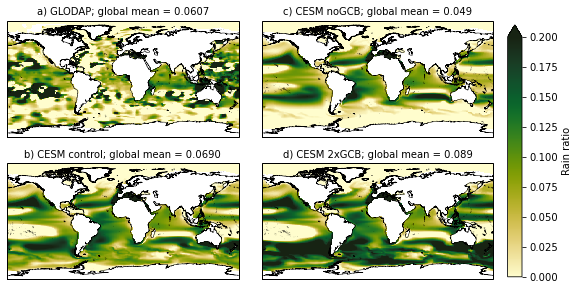

In [69]:
fig = plt.figure(figsize=(10,5))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- GLODAP panel
ax = fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) GLODAP; global mean = 0.0607', fontsize=10,x=0.5, y=1)
pc1=ax.pcolormesh(rain_ratio.lon, rain_ratio.lat,rain_ratio, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())


#---- CESM panel control
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio)
ax = fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) CESM control; global mean = 0.0690', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())


#---- CESM panel noGCB
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio_noGCB)
ax = fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) CESM noGCB; global mean = 0.049', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())



#---- CESM panel 2xGCB
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio_2xGCB)
ax = fig.add_subplot(2,2,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('d) CESM 2xGCB; global mean = 0.089', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field,vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())



fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio',extend='max')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/rainratio.png',dpi=600, bbox_inches='tight',format='png');


In [44]:
### calculate differences

noGCBdiff=cesm_rain_ratio_noGCB - cesm_rain_ratio
GCB2xdiff=cesm_rain_ratio_2xGCB - cesm_rain_ratio




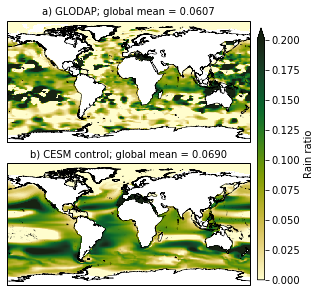

In [45]:
fig = plt.figure(figsize=(5,5))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- GLODAP panel
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) GLODAP; global mean = 0.0607', fontsize=10,x=0.5, y=1)
pc1=ax.pcolormesh(rain_ratio.lon, rain_ratio.lat,rain_ratio, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())


#---- CESM panel control
lon,lat,field=adjust_pop_grid(lons, lats, cesm_rain_ratio)
ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) CESM control; global mean = 0.0690', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=0.2, cmap=cmocean.cm.speed,
                 transform=ccrs.PlateCarree())




fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio',extend='max')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/rainratio_leftside.png',dpi=600, bbox_inches='tight',format='png');


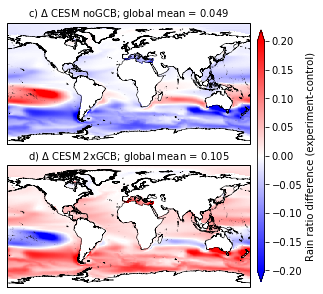

In [46]:
fig = plt.figure(figsize=(5,5))
#plt.suptitle('Rain ratio, Sarmiento et al., 2002 method: GLODAP and CESM', fontsize=14)

#---- CESM panel noGCB
lon,lat,field=adjust_pop_grid(lons, lats, noGCBdiff)
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) $\Delta$ CESM noGCB; global mean = 0.049', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field, vmin=-0.2, vmax=0.2, cmap='bwr',
                 transform=ccrs.PlateCarree())


#---- CESM panel 2xGCB
lon,lat,field=adjust_pop_grid(lons, lats, GCB2xdiff)
ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('d) $\Delta$ CESM 2xGCB; global mean = 0.105', fontsize=10,x=0.5, y=1)
pc2=ax.pcolormesh(lon, lat, field,vmin=-0.2, vmax=0.2, cmap='bwr',
                 transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc2, cax=cbar_ax,label='Rain ratio difference (experiment-control)',extend='both')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/rainratio_rightside.png',dpi=600, bbox_inches='tight',format='png');


#### Take a look a rain ratio averaged in biomes

In [42]:
ds_biomes = xr.open_dataset('/glade/work/kristenk/ocean_masks/fay_mckinley_1deg_biomes.nc',decode_times=False,decode_coords=False)

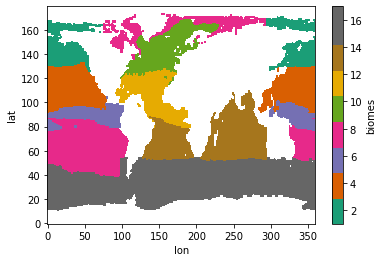

In [43]:
ds_biomes.biomes.plot(cmap=plt.cm.get_cmap('Dark2',17))

In [44]:
rr_biomes=np.empty([17])

In [45]:
rain_ratio_area=rain_ratio * ds['area'] #GLODAP

In [46]:
landmask=rain_ratio * 0.
landmask=landmask + 1.

area_mask=ds['area'] * landmask

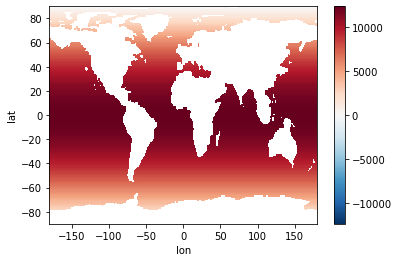

In [47]:
area_mask.plot()

In [48]:
for i in range(0,len(rr_biomes)):
    rr_biomes[i] = rain_ratio_area.where(ds_biomes.biomes==i+1).sum() / area_mask.where(ds_biomes.biomes==i+1).sum()

In [49]:
rr_biomes

array([-0.02728816,  0.01593982,  0.07685285,  0.08251431,  0.10127494,
        0.09261972,  0.22331007, -0.57665126,  0.06358805,  0.06723047,
        0.02268513,  0.08144702,  0.05518516,  0.07336435,  0.00163278,
       -0.01766346,  0.00172559])

In [50]:
glodap_biomes_rr=np.full((180, 360), np.nan)

In [51]:
for i in range(0,len(rr_biomes)):
    
    rr=rr_biomes[i]
    rr_mask=np.full((180, 360), rr)

    #make ds_biomes.biomes a numpy array with only one masked biome
    masked_biome = ds_biomes.biomes.where(ds_biomes.biomes==i+1)
    masked_biome = np.asarray(masked_biome)
    glodap_biomes_rr[~np.isnan(masked_biome)] = rr_mask[~np.isnan(masked_biome)]

In [52]:
glodap_biomes_rr=xr.DataArray(glodap_biomes_rr)
glodap_biomes_rr=glodap_biomes_rr.rename({'dim_0':'lat'})
glodap_biomes_rr=glodap_biomes_rr.rename({'dim_1':'lon'})

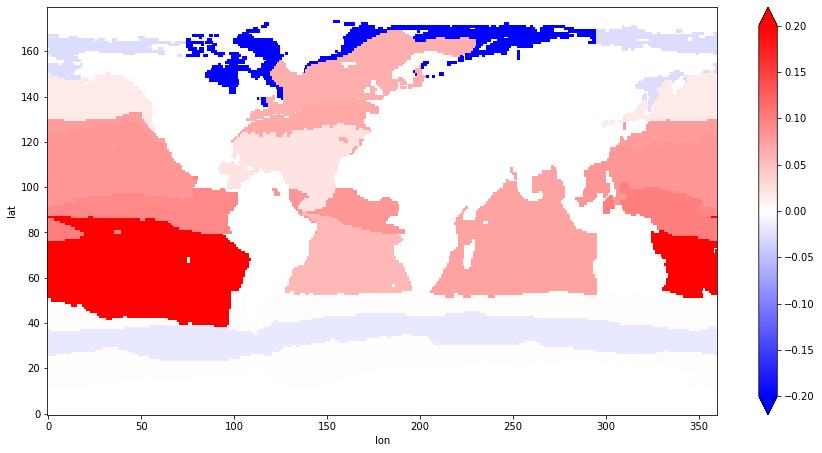

In [53]:
glodap_biomes_rr.plot(figsize=(15,7.5),vmin=-0.2,vmax=0.2,cmap='bwr')

#### and now in cesm

In [54]:
ds_biomes = xr.open_dataset('/glade/work/kristenk/ocean_masks/fay_biomes_POP_rotated.nc',decode_times=False,decode_coords=False)

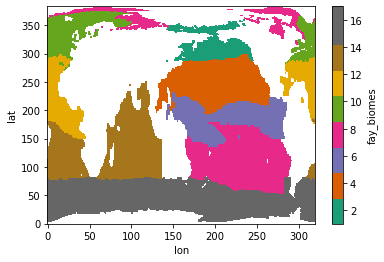

In [55]:
ds_biomes.fay_biomes.plot(cmap=plt.cm.get_cmap('Dark2',17))

In [56]:
landmask=cesm_rain_ratio * 0.
landmask=landmask + 1.

area_mask=area * landmask

In [57]:
cesm_rain_ratio_area=cesm_rain_ratio * area #CESM control

In [58]:
# for i in range(0,len(rr_biomes)):
#     print(i)
#     rr_biomes[i] = cesm_rain_ratio_area.where(ds_biomes.fay_biomes==i+1).sum() / area_mask.where(ds_biomes.fay_biomes==i+1).sum()

In [59]:
# cluster = ncar_jobqueue.NCARCluster(project='ncgd0011')
# cluster.adapt(minimum_jobs=0, maximum_jobs=30)
# client = Client(cluster)
# client

Client Scheduler: tcp://128.117.181.216:40048 Dashboard: https://jupyterhub.ucar.edu/dav/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [ ]:
rr_biomes=np.empty([17])
for i in range(0,len(rr_biomes)):
    print(i)
    rr_biomes[i] = esmlab.statistics.weighted_mean(cesm_rain_ratio.where(ds_biomes.fay_biomes==i+1), weights=area, dim=['nlat', 'nlon'])

0


### Calculate rain rain ratio the more direct way in CESM

In [62]:
cesm_rain_ratio2 = cesm_annmean_ds.CaCO3_FLUX_100m / cesm_annmean_ds.POC_FLUX_100m

In [63]:
global_mean_rr = esmlab.weighted_mean(cesm_rain_ratio2, weights=cesm_annmean_ds.TAREA, dim=['nlat', 'nlon']).compute()
global_mean_rr

<xarray.DataArray ()>
array(0.14902708)
Attributes:
    long_name:     CaCO3 Flux at 100m
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean
    coordinates:   TLAT TLONG

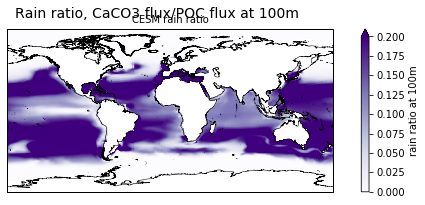

In [64]:
fig = plt.figure(figsize=(10,3))
plt.suptitle('Rain ratio, CaCO3 flux/POC flux at 100m', fontsize=14)

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
pc2=ax.pcolormesh(lons, lats, cesm_rain_ratio2, vmin=0, vmax=0.2, cmap='Purples',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='rain ratio at 100m')